# Final ISRO Approach - DenseNet201

Key Frame Captioning using DenseNet201 and GRUs. Includes Glove Embedding, captioning using Greedy Search and Beam Search and performance metrics BLEU1, BLEU2, Meteor. 


(more performance metrics can be added later)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d anindya2906/glove6b
! unzip /content/glove6b.zip -d glove6b

100% 840M/844M [00:07<00:00, 168MB/s]
100% 844M/844M [00:07<00:00, 118MB/s]
Archive:  /content/glove6b.zip
  inflating: glove6b/glove.6B.100d.txt  
  inflating: glove6b/glove.6B.200d.txt  
  inflating: glove6b/glove.6B.300d.txt  
  inflating: glove6b/glove.6B.50d.txt  


## Importing the libraries

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import sys
import os
import pandas as pd
from PIL import Image

import nltk
from nltk.translate.bleu_score import SmoothingFunction

from  keras import backend as K
from  keras.models import Model
from  keras.layers import Input, Dense, Dropout, GRU, Embedding, Flatten
from  tensorflow.keras.applications import DenseNet201, InceptionV3
from  tensorflow.keras.optimizers import RMSprop
from  keras.callbacks import ModelCheckpoint, TensorBoard
from  keras.preprocessing.text import Tokenizer
from  keras_preprocessing.sequence import pad_sequences

## Reading the Dataset

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/DivisionOfCaptions.xlsx")

In [ ]:
df = df[['Filename', 'Category', 'Caption1', 'Caption2', 'Caption3']]

In [ ]:
df.columns

Index(['Filename', 'Category', 'Caption1', 'Caption2', 'Caption3'], dtype='object')

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,Filename,Category,Caption1,Caption2,Caption3
0,Video003-Scene-015.jpg,AerialView,Top view of many green trees and buildings is ...,A picture of green colored trees and buildings...,An aerial view of a place is visible
3,Video003-Scene-018.jpg,AerialView,Aerial view of red trees on snow,Top view of snow filled ground with trees is seen,Many Red trees are captured from top
8,Video003-Scene-023.jpg,AerialView,Red trees and buildings are viewed from top,The aerial view of many red colored trees and ...,Red trees are seen on a white snowy ground
13,Video003-Scene-036.jpg,AerialView,Aerial view of many trees is seen,Red treesare viewed from top,Many Red trees are seen on a snowy white ground
19,Video003-Scene-042.jpg,AerialView,A plot of buildings and trees is seen from top,Red trees and buildings are captured from top,Aerial view of buildings and surrounding trees...
...,...,...,...,...,...
3600,Video023-Scene-053.jpg,Vehicle,A red vehicle passing through,A huge vehicle moving on a road,A red vehicle moving
3602,Video023-Scene-081.jpg,Vehicle,A red vehicle,A long big vehicle on a road,A red truck parked at roadside
3604,Video023-Scene-083.jpg,Vehicle,A Red vehicle travelling on a road,A big red truck on a road,A vehicle moving
3606,Video023-Scene-096.jpg,Vehicle,A vehicle is being unloaded,A vehicle parked on a road,A long truck on road


In [ ]:
import string
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(df.Caption1.values):
   newcaption = text_clean(caption)
   df["Caption1"].iloc[i] = newcaption.lower()
for i, caption in enumerate(df.Caption2.values):
   newcaption = text_clean(caption)
   df["Caption2"].iloc[i] = newcaption.lower()
for i, caption in enumerate(df.Caption3.values):
   newcaption = text_clean(caption)
   df["Caption3"].iloc[i] = newcaption.lower()

In [ ]:
df

,Filename,Category,Caption1,Caption2,Caption3
0,Video003-Scene-015.jpg,AerialView,top view of many green trees and buildings is...,picture of green colored trees and buildings ...,an aerial view of place is visible
3,Video003-Scene-018.jpg,AerialView,aerial view of red trees on snow,top view of snow filled ground with trees is ...,many red trees are captured from top
8,Video003-Scene-023.jpg,AerialView,red trees and buildings are viewed from top,the aerial view of many red colored trees and...,red trees are seen on white snowy ground
13,Video003-Scene-036.jpg,AerialView,aerial view of many trees is seen,red treesare viewed from top,many red trees are seen on snowy white ground
19,Video003-Scene-042.jpg,AerialView,plot of buildings and trees is seen from top,red trees and buildings are captured from top,aerial view of buildings and surrounding tree...
...,...,...,...,...,...
3600,Video023-Scene-053.jpg,Vehicle,red vehicle passing through,huge vehicle moving on road,red vehicle moving
3602,Video023-Scene-081.jpg,Vehicle,red vehicle,long big vehicle on road,red truck parked at roadside
3604,Video023-Scene-083.jpg,Vehicle,red vehicle travelling on road,big red truck on road,vehicle moving
3606,Video023-Scene-096.jpg,Vehicle,vehicle is being unloaded,vehicle parked on road,long truck on road


In [ ]:
class_names = list(df['Category'].unique())
class_names

['AerialView',
 'AirPlane',
 'Animation',
 'Building',
 'CompositionFrame',
 'Crowd',
 'DisplayScreen',
 'Forest',
 'Garden',
 'Graphics',
 'Helicopter',
 'Hospital',
 'IndoorControlRoom',
 'IndoorGeneric',
 'IndoorHome',
 'IndoorLab',
 'Interview',
 'Launch',
 'Logo',
 'Mountain',
 'OutdoorAntenna',
 'OutdoorGeneric',
 'OutdoorLaunchpad',
 'PersonCloseUp',
 'Satellite',
 'Sky',
 'Speech',
 'Text',
 'Traffic',
 'Vehicle']

In [ ]:
class_counts=dict(df['Category'].value_counts())
class_counts

{'Speech': 62,
 'OutdoorLaunchpad': 61,
 'Mountain': 45,
 'Graphics': 41,
 'IndoorLab': 39,
 'Crowd': 36,
 'Launch': 32,
 'Building': 30,
 'OutdoorAntenna': 27,
 'Hospital': 24,
 'OutdoorGeneric': 24,
 'Animation': 22,
 'Forest': 20,
 'PersonCloseUp': 20,
 'IndoorControlRoom': 19,
 'Logo': 19,
 'Interview': 12,
 'Satellite': 12,
 'DisplayScreen': 11,
 'Text': 9,
 'AerialView': 9,
 'Helicopter': 9,
 'Garden': 9,
 'Sky': 8,
 'Traffic': 7,
 'Vehicle': 7,
 'AirPlane': 5,
 'IndoorHome': 5,
 'IndoorGeneric': 5,
 'CompositionFrame': 3}

## Splitting dataframe into Training and Testing

In [ ]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()

In [ ]:
start=0
for i in class_names:
  total_count = class_counts[i]
  test_count = math.ceil(total_count * 0.15)  
  train_count = total_count - test_count

  train_df = train_df.append(df.iloc[start:start+train_count, :]) #0-7
  test_df = test_df.append(df.iloc[start+train_count: start+total_count]) #7-9
  start+=total_count 

In [ ]:
train_df

,Filename,Category,Caption1,Caption2,Caption3
0,Video003-Scene-015.jpg,AerialView,top view of many green trees and buildings is...,picture of green colored trees and buildings ...,an aerial view of place is visible
3,Video003-Scene-018.jpg,AerialView,aerial view of red trees on snow,top view of snow filled ground with trees is ...,many red trees are captured from top
8,Video003-Scene-023.jpg,AerialView,red trees and buildings are viewed from top,the aerial view of many red colored trees and...,red trees are seen on white snowy ground
13,Video003-Scene-036.jpg,AerialView,aerial view of many trees is seen,red treesare viewed from top,many red trees are seen on snowy white ground
19,Video003-Scene-042.jpg,AerialView,plot of buildings and trees is seen from top,red trees and buildings are captured from top,aerial view of buildings and surrounding tree...
...,...,...,...,...,...
3596,Video015-Scene-015.jpg,Vehicle,people standing near vehicle,vehicle with lights on,vehicle is ready to move
3599,Video022-Scene-059.jpg,Vehicle,vehicles standing together,white vehicles near each other,huge vehicle parked
3600,Video023-Scene-053.jpg,Vehicle,red vehicle passing through,huge vehicle moving on road,red vehicle moving
3602,Video023-Scene-081.jpg,Vehicle,red vehicle,long big vehicle on road,red truck parked at roadside


In [ ]:
test_df

,Filename,Category,Caption1,Caption2,Caption3
27,Video003-Scene-139.jpg,AerialView,map of city is seen from aerial view,the plot of city with buildings and trees is ...,map of city is visible with different compone...
28,Video014-Scene-076.jpg,AerialView,top view of grass and water is captured with ...,white clouds are seen from the aerial view of...,stream of water and grass is seen from top
33,Video024-Scene-009.jpg,AirPlane,building and trees view from airplane,top view from airplane,big campus visible from airplane
80,Video002-Scene-056.jpg,Animation,moon surface with dark pits and craters on it,white moon with dark circular patches,moon surface
84,Video002-Scene-060.jpg,Animation,golden satellite standing on moon surface,satellite landed on white surface,animation of satellite on moon
...,...,...,...,...,...
3577,Video025-Scene-002.jpg,Text,text on screen,text with sea as background,white text on screen
3593,Video021-Scene-120.jpg,Traffic,people walking on road,few people walking,people walking and boy on cycle
3594,Video021-Scene-236.jpg,Traffic,traffic on road,many vehicles stuck in traffic,different vehicles on road forming traffic
3606,Video023-Scene-096.jpg,Vehicle,vehicle is being unloaded,vehicle parked on road,long truck on road


In [ ]:
print("Training Dataframe Shape:", train_df.shape)
print("Testing Dataframe Shape:", test_df.shape)

Training Dataframe Shape: (523, 5)
Testing Dataframe Shape: (109, 5)


In [ ]:
filenames_train=train_df["Filename"]
filenames_train=list(filenames_train)
filenames_train

['Video003-Scene-015.jpg',
 'Video003-Scene-018.jpg',
 'Video003-Scene-023.jpg',
 'Video003-Scene-036.jpg',
 'Video003-Scene-042.jpg',
 'Video003-Scene-046.jpg',
 'Video003-Scene-051.jpg',
 'Video006-Scene-070.jpg',
 'Video006-Scene-071.jpg',
 'Video006-Scene-072.jpg',
 'Video021-Scene-160.jpg',
 'Video001-Scene-002.jpg',
 'Video001-Scene-027.jpg',
 'Video001-Scene-028.jpg',
 'Video001-Scene-030.jpg',
 'Video001-Scene-033.jpg',
 'Video001-Scene-044.jpg',
 'Video001-Scene-050.jpg',
 'Video001-Scene-054.jpg',
 'Video001-Scene-056.jpg',
 'Video001-Scene-057.jpg',
 'Video002-Scene-011.jpg',
 'Video002-Scene-015.jpg',
 'Video002-Scene-018.jpg',
 'Video002-Scene-020.jpg',
 'Video002-Scene-040.jpg',
 'Video002-Scene-045.jpg',
 'Video002-Scene-047.jpg',
 'Video002-Scene-052.jpg',
 'Video003-Scene-191.jpg',
 'Video003-Scene-221.jpg',
 'Video007-Scene-073.jpg',
 'Video008-Scene-016.jpg',
 'Video008-Scene-090.jpg',
 'Video008-Scene-091.jpg',
 'Video008-Scene-094.jpg',
 'Video009-Scene-012.jpg',
 

In [ ]:
filenames_test=test_df["Filename"]
filenames_test=list(filenames_test)
filenames_test

['Video003-Scene-139.jpg',
 'Video014-Scene-076.jpg',
 'Video024-Scene-009.jpg',
 'Video002-Scene-056.jpg',
 'Video002-Scene-060.jpg',
 'Video002-Scene-065.jpg',
 'Video002-Scene-070.jpg',
 'Video017-Scene-216.jpg',
 'Video021-Scene-238.jpg',
 'Video022-Scene-110.jpg',
 'Video022-Scene-146.jpg',
 'Video025-Scene-003.jpg',
 'Video008-Scene-045.jpg',
 'Video020-Scene-086.jpg',
 'Video021-Scene-034.jpg',
 'Video021-Scene-056.jpg',
 'Video023-Scene-052.jpg',
 'Video023-Scene-419.jpg',
 'Video023-Scene-428.jpg',
 'Video021-Scene-127.jpg',
 'Video023-Scene-195.jpg',
 'Video021-Scene-047.jpg',
 'Video021-Scene-050.jpg',
 'Video021-Scene-053.jpg',
 'Video020-Scene-136.jpg',
 'Video020-Scene-141.jpg',
 'Video021-Scene-017.jpg',
 'Video021-Scene-033.jpg',
 'Video022-Scene-079.jpg',
 'Video022-Scene-088.jpg',
 'Video022-Scene-118.jpg',
 'Video023-Scene-167.jpg',
 'Video024-Scene-032.jpg',
 'Video017-Scene-176.jpg',
 'Video021-Scene-131.jpg',
 'Video017-Scene-272.jpg',
 'Video017-Scene-273.jpg',
 

In [ ]:
captions_train_df=train_df[['Caption1', 'Caption2','Caption3']]
captions_train_df

,Caption1,Caption2,Caption3
0,top view of many green trees and buildings is...,picture of green colored trees and buildings ...,an aerial view of place is visible
3,aerial view of red trees on snow,top view of snow filled ground with trees is ...,many red trees are captured from top
8,red trees and buildings are viewed from top,the aerial view of many red colored trees and...,red trees are seen on white snowy ground
13,aerial view of many trees is seen,red treesare viewed from top,many red trees are seen on snowy white ground
19,plot of buildings and trees is seen from top,red trees and buildings are captured from top,aerial view of buildings and surrounding tree...
...,...,...,...
3596,people standing near vehicle,vehicle with lights on,vehicle is ready to move
3599,vehicles standing together,white vehicles near each other,huge vehicle parked
3600,red vehicle passing through,huge vehicle moving on road,red vehicle moving
3602,red vehicle,long big vehicle on road,red truck parked at roadside


In [ ]:
captions_test_df=test_df[['Caption1', 'Caption2','Caption3']]
captions_test_df

,Caption1,Caption2,Caption3
27,map of city is seen from aerial view,the plot of city with buildings and trees is ...,map of city is visible with different compone...
28,top view of grass and water is captured with ...,white clouds are seen from the aerial view of...,stream of water and grass is seen from top
33,building and trees view from airplane,top view from airplane,big campus visible from airplane
80,moon surface with dark pits and craters on it,white moon with dark circular patches,moon surface
84,golden satellite standing on moon surface,satellite landed on white surface,animation of satellite on moon
...,...,...,...
3577,text on screen,text with sea as background,white text on screen
3593,people walking on road,few people walking,people walking and boy on cycle
3594,traffic on road,many vehicles stuck in traffic,different vehicles on road forming traffic
3606,vehicle is being unloaded,vehicle parked on road,long truck on road


In [ ]:
def return_list_of_captions(captions_df):
  captions = []
  for i, row in captions_df.iterrows():
    temp = []
    for j in range(3):
      temp.append(row[j])
    captions.append(temp)
  return captions

In [ ]:
captions_train=return_list_of_captions(captions_train_df)
captions_test=return_list_of_captions(captions_test_df)

In [ ]:
captions_train

[[' top view of many green trees and buildings is seen',
  ' picture of green colored trees and buildings is captured from above',
  ' an aerial view of place is visible'],
 [' aerial view of red trees on snow',
  ' top view of snow filled ground with trees is seen',
  ' many red trees are captured from top'],
 [' red trees and buildings are viewed from top',
  ' the aerial view of many red colored trees and plot of building is seen',
  ' red trees are seen on white snowy ground'],
 [' aerial view of many trees is seen',
  ' red treesare viewed from top',
  ' many red trees are seen on snowy white ground'],
 [' plot of buildings and trees is seen from top',
  ' red trees and buildings are captured from top',
  ' aerial view of buildings and surrounding trees is seen'],
 [' red trees are seen from top in hazy climate',
  ' the aerial view of red trees and road is seen from cloudy sky',
  ' red trees are seen from top in misty atmosphere'],
 [' top view of red trees',
  ' dark image of v

In [ ]:
captions_test

[[' map of city is seen from aerial view',
  ' the plot of city with buildings and trees is seen from top',
  ' map of city is visible with different components from above'],
 [' top view of grass and water is captured with clouds',
  ' white clouds are seen from the aerial view of water filled wth algae',
  ' stream of water and grass is seen from top'],
 [' building and trees view from airplane',
  ' top view from airplane',
  ' big campus visible from airplane'],
 [' moon surface with dark pits and craters on it',
  ' white moon with dark circular patches',
  ' moon surface'],
 [' golden satellite standing on moon surface',
  ' satellite landed on white surface',
  ' animation of satellite on moon'],
 [' wheels of spacecraft printing indian emblem on moon surface',
  ' spacecraft moving on moon surface',
  ' grey wheels moving on white surface'],
 [' spacecraft landed on moon surface',
  ' golden spacecraft on white surface',
  ' golden box like spacecraft on white surface in space'

In [ ]:
train_captions={}
c=0
for i in filenames_train:
  train_captions[i]=captions_train[c]
  c+=1

In [ ]:
train_captions

{'Video003-Scene-015.jpg': [' top view of many green trees and buildings is seen',
  ' picture of green colored trees and buildings is captured from above',
  ' an aerial view of place is visible'],
 'Video003-Scene-018.jpg': [' aerial view of red trees on snow',
  ' top view of snow filled ground with trees is seen',
  ' many red trees are captured from top'],
 'Video003-Scene-023.jpg': [' red trees and buildings are viewed from top',
  ' the aerial view of many red colored trees and plot of building is seen',
  ' red trees are seen on white snowy ground'],
 'Video003-Scene-036.jpg': [' aerial view of many trees is seen',
  ' red treesare viewed from top',
  ' many red trees are seen on snowy white ground'],
 'Video003-Scene-042.jpg': [' plot of buildings and trees is seen from top',
  ' red trees and buildings are captured from top',
  ' aerial view of buildings and surrounding trees is seen'],
 'Video003-Scene-046.jpg': [' red trees are seen from top in hazy climate',
  ' the aerial

In [ ]:
num_images_train = len(filenames_train)
num_images_train

523

In [ ]:
root_dir="/content/drive/MyDrive/MainFrames"

In [ ]:
def load_image(path, size=None):
  """
  Load the image from the given file-path and resize it
  to the given size if not None.
  """

  # Load the image using PIL.
  img = Image.open(path)

  # Resize image if desired.
  if not size is None:
      img = img.resize(size=size, resample=Image.LANCZOS)
      
  img = np.array(img)
  img = img / 255.0

  # Convert 2-dim gray-scale array to 3-dim RGB array.
  if (len(img.shape) == 2):
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
  return img

In [ ]:
def show_image(idx,train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = root_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = root_dir
        filename = filenames_test[idx]
        captions = captions_test[idx]

    # Path for the image-file.
    path = os.path.join(dir, filename)
    for caption in captions:
        print(caption)
    
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

 animation of flying airplane
 an orange airplane
 airplane flying in sky


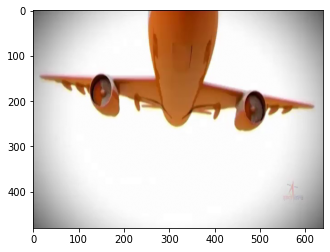

In [ ]:
show_image(idx=10,train=True)

## DenseNet201 Model for Processing Images

In [ ]:
image_model = DenseNet201(include_top=True, weights='imagenet')

82524592/82524592 [==============================] - 1s 0us/step


In [ ]:
image_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
transfer_layer = image_model.get_layer('avg_pool')

In [ ]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [ ]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

In [ ]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

1920

## Processing Images

In [ ]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [ ]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    shape = (batch_size,) + img_size + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (num_images, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Initialize index into the filenames.
    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # End-index for this batch.
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size.
        current_batch_size = end_index - start_index

        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img

        # Use the pre-trained image-model to process the image.
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [ ]:
transfer_values_train = process_images(root_dir,filenames_train, batch_size=32)

1/1 [==============================] - 5s 5s/step



In [ ]:
transfer_values_train

array([[2.3150e-04, 5.3787e-04, 1.2455e-03, ..., 0.0000e+00, 6.0196e-03,
        2.2107e-01],
       [2.3770e-04, 1.7989e-04, 1.5440e-03, ..., 5.4474e-02, 6.6162e-02,
        5.5127e-01],
       [2.5415e-04, 2.5463e-04, 1.2445e-03, ..., 0.0000e+00, 3.3130e-01,
        3.4210e-02],
       ...,
       [1.1182e-04, 1.0118e-03, 1.2045e-03, ..., 1.1377e+00, 2.1912e-02,
        3.0350e-02],
       [1.0127e-04, 1.4429e-03, 9.4128e-04, ..., 1.1465e+00, 1.3818e-01,
        1.2915e-01],
       [1.1951e-04, 1.2970e-03, 4.2319e-04, ..., 1.5742e+00, 7.4561e-01,
        4.3427e-02]], dtype=float16)

In [ ]:
transfer_values_test = process_images(root_dir,filenames_test, batch_size=32)

1/1 [==============================] - 2s 2s/step



In [ ]:
transfer_values_test

array([[1.230e-04, 1.495e-03, 2.227e-04, ..., 0.000e+00, 8.613e-01,
        5.380e-02],
       [1.578e-04, 6.032e-04, 1.007e-03, ..., 1.194e+00, 4.178e-02,
        8.726e-01],
       [1.055e-04, 3.152e-04, 9.713e-04, ..., 4.849e-01, 3.056e-02,
        4.919e-01],
       ...,
       [7.695e-05, 5.045e-04, 1.132e-03, ..., 4.637e+00, 9.302e-01,
        1.495e-03],
       [1.266e-04, 1.093e-03, 1.069e-03, ..., 8.423e-01, 3.074e-01,
        2.216e-01],
       [1.612e-04, 1.005e-03, 9.255e-04, ..., 1.469e+00, 4.377e-01,
        5.200e-01]], dtype=float16)

In [ ]:
print("Encoded Train Images Shape:", transfer_values_train.shape)
print("Encoded Test Images Shape Shape:", transfer_values_test.shape)

Encoded Train Images Shape: (523, 1920)
Encoded Test Images Shape Shape: (109, 1920)


## Tokenizing

In [ ]:
mark_start = 'ssss'
mark_end = ' eeee'

In [ ]:
def mark_captions(captions_listlist):
  captions_marked = [[mark_start + caption + mark_end
                      for caption in captions_list]
                      for captions_list in captions_listlist]
  
  return captions_marked

In [ ]:
captions_train[0]

[' top view of many green trees and buildings is seen',
 ' picture of green colored trees and buildings is captured from above',
 ' an aerial view of place is visible']

In [ ]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss top view of many green trees and buildings is seen eeee',
 'ssss picture of green colored trees and buildings is captured from above eeee',
 'ssss an aerial view of place is visible eeee']

In [ ]:
print(len(captions_train_marked), len(captions_train))

523 523


In [ ]:
def flatten(captions_listlist):
  captions_list = [caption
                    for captions_list in captions_listlist
                    for caption in captions_list]
  
  return captions_list

In [ ]:
captions_train_flat = flatten(captions_train_marked)

In [ ]:
captions_train_flat

['ssss top view of many green trees and buildings is seen eeee',
 'ssss picture of green colored trees and buildings is captured from above eeee',
 'ssss an aerial view of place is visible eeee',
 'ssss aerial view of red trees on snow eeee',
 'ssss top view of snow filled ground with trees is seen eeee',
 'ssss many red trees are captured from top eeee',
 'ssss red trees and buildings are viewed from top eeee',
 'ssss the aerial view of many red colored trees and plot of building is seen eeee',
 'ssss red trees are seen on white snowy ground eeee',
 'ssss aerial view of many trees is seen eeee',
 'ssss red treesare viewed from top eeee',
 'ssss many red trees are seen on snowy white ground eeee',
 'ssss plot of buildings and trees is seen from top eeee',
 'ssss red trees and buildings are captured from top eeee',
 'ssss aerial view of buildings and surrounding trees is seen eeee',
 'ssss red trees are seen from top in hazy climate eeee',
 'ssss the aerial view of red trees and road is

In [ ]:
len(captions_train_flat)

1569

In [ ]:
num_words = 15000

In [ ]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words.
        # word_index is a dictionary. its values are tokens and the keys are words
        # opposite to index_to_word
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""
        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""
        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [ ]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 31.9 ms, sys: 0 ns, total: 31.9 ms
Wall time: 34.3 ms


In [ ]:
tokenizer.index_to_word

{1: 'ssss',
 2: 'eeee',
 3: 'the',
 4: 'is',
 5: 'of',
 6: 'are',
 7: 'in',
 8: 'seen',
 9: 'people',
 10: 'and',
 11: 'rocket',
 12: 'on',
 13: 'man',
 14: 'with',
 15: 'to',
 16: 'sitting',
 17: 'few',
 18: 'some',
 19: 'white',
 20: 'an',
 21: 'trees',
 22: 'standing',
 23: 'satellite',
 24: 'building',
 25: 'screen',
 26: 'at',
 27: 'person',
 28: 'being',
 29: 'view',
 30: 'inside',
 31: 'launch',
 32: 'visible',
 33: 'antenna',
 34: 'water',
 35: 'computer',
 36: 'black',
 37: 'woman',
 38: 'from',
 39: 'be',
 40: 'background',
 41: 'giving',
 42: 'room',
 43: 'by',
 44: 'forest',
 45: 'doctor',
 46: 'sky',
 47: 'component',
 48: 'many',
 49: 'talking',
 50: 'space',
 51: 'blue',
 52: 'lab',
 53: 'machine',
 54: 'road',
 55: 'part',
 56: 'up',
 57: 'large',
 58: 'working',
 59: 'garden',
 60: 'red',
 61: 'through',
 62: 'logo',
 63: 'mountains',
 64: 'while',
 65: 'near',
 66: 'gathered',
 67: 'speaking',
 68: 'earth',
 69: 'using',
 70: 'facility',
 71: 'green',
 72: 'wearing',


In [ ]:
tokenizer.word_index

{'ssss': 1,
 'eeee': 2,
 'the': 3,
 'is': 4,
 'of': 5,
 'are': 6,
 'in': 7,
 'seen': 8,
 'people': 9,
 'and': 10,
 'rocket': 11,
 'on': 12,
 'man': 13,
 'with': 14,
 'to': 15,
 'sitting': 16,
 'few': 17,
 'some': 18,
 'white': 19,
 'an': 20,
 'trees': 21,
 'standing': 22,
 'satellite': 23,
 'building': 24,
 'screen': 25,
 'at': 26,
 'person': 27,
 'being': 28,
 'view': 29,
 'inside': 30,
 'launch': 31,
 'visible': 32,
 'antenna': 33,
 'water': 34,
 'computer': 35,
 'black': 36,
 'woman': 37,
 'from': 38,
 'be': 39,
 'background': 40,
 'giving': 41,
 'room': 42,
 'by': 43,
 'forest': 44,
 'doctor': 45,
 'sky': 46,
 'component': 47,
 'many': 48,
 'talking': 49,
 'space': 50,
 'blue': 51,
 'lab': 52,
 'machine': 53,
 'road': 54,
 'part': 55,
 'up': 56,
 'large': 57,
 'working': 58,
 'garden': 59,
 'red': 60,
 'through': 61,
 'logo': 62,
 'mountains': 63,
 'while': 64,
 'near': 65,
 'gathered': 66,
 'speaking': 67,
 'earth': 68,
 'using': 69,
 'facility': 70,
 'green': 71,
 'wearing': 72,


In [ ]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

1

In [ ]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

2

In [ ]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 23.2 ms, sys: 3.04 ms, total: 26.3 ms
Wall time: 28.5 ms


In [ ]:
tokens_train

[[[1, 105, 29, 5, 48, 71, 21, 10, 106, 4, 8, 2],
  [1, 572, 5, 71, 118, 21, 10, 106, 4, 258, 38, 365, 2],
  [1, 20, 189, 29, 5, 159, 4, 32, 2]],
 [[1, 189, 29, 5, 60, 21, 12, 259, 2],
  [1, 105, 29, 5, 259, 305, 84, 14, 21, 4, 8, 2],
  [1, 48, 60, 21, 6, 258, 38, 105, 2]],
 [[1, 60, 21, 10, 106, 6, 205, 38, 105, 2],
  [1, 3, 189, 29, 5, 48, 60, 118, 21, 10, 438, 5, 24, 4, 8, 2],
  [1, 60, 21, 6, 8, 12, 19, 439, 84, 2]],
 [[1, 189, 29, 5, 48, 21, 4, 8, 2],
  [1, 60, 573, 205, 38, 105, 2],
  [1, 48, 60, 21, 6, 8, 12, 439, 19, 84, 2]],
 [[1, 438, 5, 106, 10, 21, 4, 8, 38, 105, 2],
  [1, 60, 21, 10, 106, 6, 258, 38, 105, 2],
  [1, 189, 29, 5, 106, 10, 306, 21, 4, 8, 2]],
 [[1, 60, 21, 6, 8, 38, 105, 7, 440, 574, 2],
  [1, 3, 189, 29, 5, 60, 21, 10, 54, 4, 8, 38, 260, 46, 2],
  [1, 60, 21, 6, 8, 38, 105, 7, 307, 441, 2]],
 [[1, 105, 29, 5, 60, 21, 2],
  [1, 93, 94, 5, 29, 5, 60, 176, 105, 2],
  [1, 17, 60, 21, 6, 258, 38, 365, 2]],
 [[1, 19, 111, 229, 7, 151, 2],
  [1, 160, 95, 19, 111, 7, 

## Batch Data Generator

In [ ]:
def get_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    # Initialize an empty list for the results.
    result = []
    # For each of the indices.

    for i in idx:
      # The index i points to an image in the training-set.
      # Each image in the training-set has at least 5 captions
      # which have been converted to tokens in tokens_train.
      # We want to select one of these token-sequences at random.
      # Get a random index for a token-sequence.
      for j in range(len(tokens_train[i])):
      
      #j = np.random.choice(len(tokens_train[i]))
      # Get the j'th token-sequence for image i.

        tokens = tokens_train[i][j]
      # Add this token-sequence to the list of results.
      
        result.append(tokens)
    return result

In [ ]:
def get_transfer_values(idx):
  l = []
  for i in idx:
    for j in range(3):
      l.append(transfer_values_train[i])
  return l

In [ ]:
def batch_generator(batch_size):
  """ Generator function for creating random batches of training-data. Note 
  that it selects the data completely randomly for each batch, corresponding
  to sampling of the training-set with replacement. This means it is possible 
  to sample the same data multiple times within a single epoch - and it is 
  also possible that some data is not sampled at all within an epoch. 
  However, all the data should be unique within a single batch. """

  # Infinite loop.
  while True:
    # Get a list of random indices for images in the training-set.
    idx = np.random.randint(num_images_train, size=batch_size)
    
    # Get the pre-computed transfer-values for those images.
    # These are the outputs of the pre-trained image-model.
    transfer_values = transfer_values_train[idx]

    # For each of the randomly chosen images there are
    # at least 5 captions describing the contents of the image.
    # Select one of those captions at random and get the
    # associated sequence of integer-tokens.
    tokens = get_caption_tokens(idx)

    # Count the number of tokens in all these token-sequences.
    num_tokens = [len(t) for t in tokens]

    # print(tokens, num_tokens)

    
    # Max number of tokens.
    max_tokens = np.max(num_tokens)
    # print("String", max_tokens)

    # Pad all the other token-sequences with zeros
    # so they all have the same length and can be
    # input to the neural network as a numpy array.
    tokens_padded = pad_sequences(tokens,
                                  maxlen=max_tokens,
                                  padding='post',
                                  truncating='post')


    # Further prepare the token-sequences.
    # The decoder-part of the neural network
    # will try to map the token-sequences to
    # themselves shifted one time-step.
    decoder_input_data = tokens_padded[:, 0:-1]
    decoder_output_data = tokens_padded[:, 1:]

    temp = np.array(get_transfer_values(idx))


    # Dict for the input-data. Because we have
    # several inputs, we use a named dict to
    # ensure that the data is assigned correctly.
    x_data = \
    {
        'decoder_input': decoder_input_data,
        'transfer_values_input': temp
    }

    # Dict for the output-data.
    y_data = \
    {
        'decoder_output': decoder_output_data
    }
    
    yield (x_data, y_data)

In [ ]:
batch_size = 32

In [ ]:
generator = batch_generator(batch_size=batch_size)

In [ ]:
batch = next(generator)
batch_x = batch[0]
batch_y = batch[1]

In [ ]:
batch_x["decoder_input"][0]

array([  1, 464,   4,   8,   7,  44,   2,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [ ]:
batch_x['transfer_values_input'][0]

array([2.2626e-04, 6.6519e-04, 1.0986e-03, ..., 5.1392e-02, 1.0706e-01,
       4.1504e-01], dtype=float16)

In [ ]:
batch_y['decoder_output'][0]

array([464,   4,   8,   7,  44,   2,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [ ]:
print(batch_x["decoder_input"].shape, batch_x["transfer_values_input"].shape, batch_y['decoder_output'].shape) 

(96, 13) (96, 1920) (96, 13)


## Decoder Model & Glove Embedding

In [ ]:
num_captions_train = [len(captions) for captions in captions_train]

In [ ]:
total_num_captions_train = np.sum(num_captions_train)
total_num_captions_train

1569

In [ ]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

49

In [ ]:
state_size = 512
embedding_size = 200

transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

decoder_input = Input(shape=(None, ), name='decoder_input')

In [ ]:
word2vec = {}
for line in open("glove6b/glove.6B.200d.txt",encoding="utf-8"):
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:],dtype="float32")
    word2vec[word] = vec

In [ ]:
replaced_count = 0
embedding_matrix = np.random.uniform(-1,1,(num_words,embedding_size))
for word,i in tokenizer.word_index.items():
    vec = word2vec.get(word)
    if vec is not None:
        embedding_matrix[i] = vec
        replaced_count += 1
        
print(replaced_count)

853


In [ ]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              weights=[embedding_matrix],
                              trainable=True,
                              name="decoder_embedding"
                             )

decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)
decoder_gru4 = GRU(state_size, name='decoder_gru4',
                   return_sequences=True)

decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [ ]:
def connect_decoder(transfer_values):

    initial_state = decoder_transfer_map(transfer_values)

    net = decoder_input    
    net = decoder_embedding(net)
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = Dropout(0.5)(net)
    net = decoder_gru3(net, initial_state=initial_state)
    net = Dropout(0.5)(net)
    net = decoder_gru4(net, initial_state=initial_state)
    
    decoder_output = decoder_dense(net)    
    return decoder_output

  
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

In [ ]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [ ]:
decoder_model.compile(optimizer=RMSprop(lr=1e-3),
                      loss=sparse_cross_entropy)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
path_checkpoint = 'Model'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [ ]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [ ]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unsuccessful TensorSliceReader constructor: Failed to find any matching files for Model


In [ ]:
%%time
history = decoder_model.fit(x=generator,
                  steps_per_epoch=steps_per_epoch,
                  epochs=50,
                  callbacks=callbacks)

Epoch 1/50
49/49 [==============================] - ETA: 0s - loss: 3.2712
Epoch 1: saving model to Model
49/49 [==============================] - 9s 57ms/step - loss: 3.2712
Epoch 2/50
48/49 [============================>.] - ETA: 0s - loss: 2.2255
Epoch 2: saving model to Model
49/49 [==============================] - 3s 57ms/step - loss: 2.2281
Epoch 3/50
48/49 [============================>.] - ETA: 0s - loss: 1.9744
Epoch 3: saving model to Model
49/49 [==============================] - 3s 57ms/step - loss: 1.9704
Epoch 4/50
49/49 [==============================] - ETA: 0s - loss: 1.5717
Epoch 4: saving model to Model
49/49 [==============================] - 3s 59ms/step - loss: 1.5717
Epoch 5/50
49/49 [==============================] - ETA: 0s - loss: 1.2740
Epoch 5: saving model to Model
49/49 [==============================] - 3s 58ms/step - loss: 1.2740
Epoch 6/50
49/49 [==============================] - ETA: 0s - loss: 1.0390
Epoch 6: saving model to Model
49/49 [============

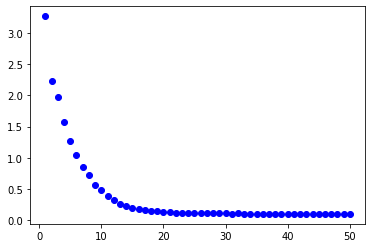

In [ ]:
loss=history.history['loss']
epochs= range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss, 'bo', label='Training loss')
plt.show()

In [ ]:
decoder_model.save('Final_ISRO_DenseNet201_Epoch50.h5')

In [ ]:
image_model_transfer.save('image_model_transfer.h5')

In [ ]:
import pickle
pickle.dump(transfer_values_train, open(os.path.join( 'transfer_values_train.pkl'), 'wb'))
pickle.dump(transfer_values_test, open(os.path.join( 'transfer_values_test.pkl'), 'wb'))
pickle.dump(tokenizer, open(os.path.join( 'tokenizer.pkl'), 'wb'))

In [ ]:
with open('/content/transfer_values_train.pkl', 'rb') as pt:
    check_var = pickle.load(pt)

In [ ]:
check_var.shape

(523, 1920)

In [ ]:
check_var

array([[2.3150e-04, 5.3787e-04, 1.2455e-03, ..., 0.0000e+00, 6.0196e-03,
        2.2107e-01],
       [2.3770e-04, 1.7989e-04, 1.5440e-03, ..., 5.4474e-02, 6.6162e-02,
        5.5127e-01],
       [2.5415e-04, 2.5463e-04, 1.2445e-03, ..., 0.0000e+00, 3.3130e-01,
        3.4210e-02],
       ...,
       [1.1182e-04, 1.0118e-03, 1.2045e-03, ..., 1.1377e+00, 2.1912e-02,
        3.0350e-02],
       [1.0127e-04, 1.4429e-03, 9.4128e-04, ..., 1.1465e+00, 1.3818e-01,
        1.2915e-01],
       [1.1951e-04, 1.2970e-03, 4.2319e-04, ..., 1.5742e+00, 7.4561e-01,
        4.3427e-02]], dtype=float16)

## Results

In [ ]:
predicted_captions=[]

### Greedy Search

In [ ]:
def greedy_search(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """
    # ---------------------------ENCODE IMAGE--------------------------------
    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)
    
    # -------------------------------------------------------------------
    
    
    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start #1

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict(), but it would make the code
        # much more complicated.
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)
#         print(decoder_output.shape) (1,30,15000) for every iteration
        
        # Get the last predicted token as a one-hot encoded array.
        # we just need the index of the largest element so it doesn't matter.
        token_onehot = decoder_output[0, count_tokens, :]
#         print(token_onehot.shape) (15000, ) for every iteration
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
#         print(token_int) #the token of a word with the highest score
        
        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)
#         print(sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
#     print(output_tokens)
    # Plot the image.
    # plt.imshow(image)
    # plt.show()

    predicted_caption=output_text.split()
    del (predicted_caption[-1])
    output_text = " "
    output_text = output_text.join(predicted_caption)

    # Print the predicted caption.
    # print("Predicted caption:")
    # print(output_text)
    # print()
    return predicted_caption

### Beam Search

In [ ]:
def beam_search(beam_index, image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)
    
    token_int = [token_start]
    start_word = [[token_int, 0.0]]
    count_tokens = 0 
    while len(start_word[0][0])<max_tokens:
        temp = []
        
        for s in start_word:
            par_caps = pad_sequences([s[0]], maxlen=max_tokens, padding='post')
            preds = decoder_model.predict([transfer_values,par_caps], verbose=0)
            token_onehot = preds[0, count_tokens, :]
#             print(token_onehot.shape)
            word_preds = np.argsort(token_onehot)[-beam_index:]
#             print(word_preds.shape)
            
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += token_onehot[w]
                temp.append([next_cap, prob])
                  
        start_word = temp
        count_tokens+=1
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
                  
    start_word = start_word[-1][0]
    intermediate_caption = [tokenizer.token_to_word(i) for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'eeee':
            final_caption.append(i)
        else:
            break

    # final_caption = ' '.join(final_caption[1:])
    return final_caption[1:]

### Testing on Images

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import random

In [ ]:
def meteor_greedy():
  sum = 0
  for idx in range(len(captions_test)):
    data_dir = root_dir
    filename = filenames_test[idx]
    captions = captions_test[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption=list(greedy_search(image_path=path))
    
    true_caption1=captions[0].split()
    true_caption2=captions[1].split()
    true_caption3=captions[2].split()

    meteor_score1 = nltk.translate.meteor_score.meteor_score([predicted_caption], true_caption1)
    meteor_score2 = nltk.translate.meteor_score.meteor_score([predicted_caption], true_caption2)
    meteor_score3 = nltk.translate.meteor_score.meteor_score([predicted_caption], true_caption3)
    meteor_score = max(meteor_score1, meteor_score2, meteor_score3)
    sum+=meteor_score
  return (sum/len(captions_test))

In [ ]:
def meteor_beam(beam_index):
  sum = 0
  for idx in range(len(captions_test)):
    data_dir = root_dir
    filename = filenames_test[idx]
    captions = captions_test[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption=list(beam_search(beam_index, image_path=path))

    true_caption1=captions[0].split()
    true_caption2=captions[1].split()
    true_caption3=captions[2].split()

    meteor_score1 = nltk.translate.meteor_score.meteor_score([predicted_caption], true_caption1)
    meteor_score2 = nltk.translate.meteor_score.meteor_score([predicted_caption], true_caption2)
    meteor_score3 = nltk.translate.meteor_score.meteor_score([predicted_caption], true_caption3)
    meteor_score = max(meteor_score1, meteor_score2, meteor_score3)
    sum+=meteor_score
  return (sum/len(captions_test))

In [ ]:
print("Meteor Score using Greedy Search", meteor_greedy())

In [ ]:
print("Meteor Score using Beam Search (k=3)", meteor_beam(3))

In [ ]:
print("Meteor Score using Beam Search (k=5)", meteor_beam(5))

In [ ]:
def mean_BLEU_greedy(k):
  if k==1:
    wts = (1,0,0,0)
  elif k==2:
    wts = (0,1,0,0)
  sum = 0
  for idx in range(len(captions_test)):
    data_dir = root_dir
    filename = filenames_test[idx]
    captions = captions_test[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption=list(greedy_search(image_path=path))
    
    true_caption1=captions[0].split()
    true_caption2=captions[1].split()
    true_caption3=captions[2].split()

    smoother = SmoothingFunction()
    BLEUscore1 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_caption1, weights=wts, smoothing_function=smoother.method1 )
    BLEUscore2 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_caption2, weights=wts, smoothing_function=smoother.method1 )
    BLEUscore3 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_caption3, weights=wts, smoothing_function=smoother.method1 )
    BLEUscore=max(BLEUscore1,BLEUscore2,BLEUscore3)
    sum = sum + BLEUscore
  return (sum/len(captions_test))

In [ ]:
def mean_beam_BLEU(k, beam_index):
  if k==1:
    wts = (1,0,0,0)
  elif k==2:
    wts = (0,1,0,0)
  sum = 0
  for idx in range(len(captions_test)):
    data_dir = root_dir
    filename = filenames_test[idx]
    captions = captions_test[idx]

    path = os.path.join(data_dir, filename)

    predicted_caption=list(beam_search(beam_index,image_path=path))
    
    true_caption1=captions[0].split()
    true_caption2=captions[1].split()
    true_caption3=captions[2].split()

    smoother = SmoothingFunction()
    BLEUscore1 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_caption1, weights=wts, smoothing_function=smoother.method1 )
    BLEUscore2 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_caption2, weights=wts, smoothing_function=smoother.method1 )
    BLEUscore3 = nltk.translate.bleu_score.sentence_bleu([predicted_caption],true_caption3, weights=wts, smoothing_function=smoother.method1 )
    BLEUscore=max(BLEUscore1,BLEUscore2,BLEUscore3)
    sum = sum + BLEUscore
  return (sum/len(captions_test))

In [ ]:
print("BLEU1 Score using Greedy Search", mean_BLEU_greedy(1))

In [ ]:
print("BLEU1 Score using Beam Search (k=3)", mean_beam_BLEU(1, 3))

In [ ]:
print("BLEU1 Score using Beam Search (k=5)", mean_beam_BLEU(1, 5))

In [ ]:
print("BLEU2 Score using Greedy Search", mean_BLEU_greedy(2))

In [ ]:
print("BLEU2 Score using Beam Search (k=3)", mean_beam_BLEU(2, 3))

In [ ]:
print("BLEU2 Score using Beam Search (k=5)", mean_beam_BLEU(2, 5))

### Generate Keyframe

In [ ]:
import cv2

In [ ]:
def framing(video):#defining a small function named"framing" with a parameter "i" that's supposed to be provided for reading the video
    fr = []#creating an empty list named fr
    fr_pre=[]#creating an empty list named fr_pre
    cap = cv2.VideoCapture(video)#reading the video file
    while (cap.isOpened()):#This command builds a loop to check if the data is still being read from the video
        ret,frame = cap.read()#reading the data tunnel,gives two output where one tells about presence of frames(here it's ret) & the other speaks frame data(here it's frame)
        if ret == True:#checking for presence of frames
            # cv2_imshow(frame)#displaying the frames
            grayed = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)#Converting the frames to Grayscale from BGR
            canned = cv2.Canny(grayed,320,320)#For extrating edges we use Canny Edge detection method
            fr.append(frame)#Appending the read frame
            fr_pre.append(canned)#Appending the edge extracted frames
            # cv2_imshow(grayed)#Displaying the original frames
            # cv2_imshow(canned)#Displaying the edge detected frames
            k = cv2.waitKey(10) & 0XFF#this is an arrangement for displaying the video where the secs for which each frame needs to be displayed in given in the paranthesis
            if k == ord('q'):#pressing 'q' key will close the video
                break
        else:
            break
    cap.release()#Here we release the resoures
    cv2.destroyAllWindows()#Here we delete all the windows that were created during the program       
    return fr_pre,fr 

In [ ]:
def difference_of_frames(frames):
    diff = []#creatin a list variable
    for i in range(0,len(frames)-1):#defining the range
        # print(frames[i],frames[i+1])#checking the frames presence
        diff.append(cv2.absdiff(frames[i],frames[i+1]))#appending the diff between frames to the list variable so we're supposed to get only the difference between frames
    return diff

In [ ]:
def cal_threshold(diff):
  mn = np.mean(diff)#This gives mean
  st_d = np.std(diff)#This gives standard deviation
  a = 4#Setting a random value we can modify it to any value 
  ts = mn + (a * st_d)#defining the standard threshold value for the project/global threshold value
  return ts

In [ ]:
def imp_frames(diff, ts, ogframes):
  a_fr = []#Creating an empty list
  for i in range(len(diff)):#Defining the for loop to be looped over all the frames obtained after finding the frames resulted from subtracting
      mn = np.mean(diff[i])#Calculating the mean for each frame
      st_d = np.std(diff[i])#Calculating the standard deviation for each frame
      fr_ts = mn + (4*st_d)#Finding the threshold values for each frame/image
      a_fr.append([i,fr_ts])#Appending the frame number & the threshold values
  imp_fr = []#Creating an empty list
  for i,ac_tr in(a_fr):#Defining the loop on the list obtained from above code
      if ac_tr >= ts:#Comapring the threshold values to the standard threshold/global threshold values
          imp_fr.append([i,ac_tr])#Appending the list with the imp frames based on their index & the values
  key_fr = []#Creating an empty list
  for i,_ in imp_fr:#Defining the loop over the list obtained from above code
      key_fr.append(ogframes[i])#This extracts the frames based on the index of frames 
  return key_fr

In [ ]:
def final_image(video):
  frames,ogframes = framing(video)#calling function framing & then extracting the images 
  diff=difference_of_frames(frames)  
  ts=cal_threshold(diff) 
  key_fr=imp_frames(diff, ts, ogframes)  
  frame_no=key_fr[int(len(key_fr)/2)] #this is a frame
  cv2.imwrite("/content/Testing1.jpg",frame_no)
  return "/content/Testing1.jpg"
  cv2.destroyAllWindows()

### Generate Caption

In [ ]:
def generate_caption_test(idx):
  data_dir = root_dir
  filename = filenames_test[idx]
  captions = captions_test[idx]

  path = os.path.join(data_dir, filename)
  true_caption1=captions[0].split()
  true_caption2=captions[1].split()
  true_caption3=captions[2].split()

  print("True captions: ", end ="")
  show_image(idx,train=False)
  
  predicted_caption1=' '.join((greedy_search(image_path=path)))
  predicted_caption2=' '.join(beam_search(beam_index=3,image_path=path))
  predicted_caption3=' '.join(beam_search(beam_index=5,image_path=path))

  print("Predicted using Greedy Search", predicted_caption1)
  print("Predicted using Beam Search (k=3)", predicted_caption2)
  print("Predicted using Beam Search (k=5)", predicted_caption3)

In [ ]:
generate_caption_test(idx=24)

In [ ]:
def show_image_using_path(img_path):
    # Load the image and plot it.
    img = load_image(path)
    plt.imshow(img)
    plt.show()

In [ ]:
def generate_caption_any(image_path):

  print("True captions: ", end ="")

  predicted_caption1=' '.join((greedy_search(image_path=image_path)))
  predicted_caption2=' '.join(beam_search(beam_index=3,image_path=image_path))
  predicted_caption3=' '.join(beam_search(beam_index=5,image_path=image_path))

  print("Predicted using Greedy Search: ", predicted_caption1)
  print("Predicted using Beam Search (k=3): ", predicted_caption2)
  print("Predicted using Beam Search (k=5): ", predicted_caption3)

  show_image_using_path(image_path)

In [ ]:
path=final_image("/content/drive/MyDrive/Videos/Video023-Scene-066.mp4")
generate_caption_any(path)

In [ ]:
path=final_image("/content/drive/MyDrive/Videos/Video017-Scene-230.mp4")
generate_caption_any(path)